Neste notebook exercitei a criação de uma rede para classificação de imagens parasitadas de malária. O dataset empregado foi o Malaria Dataset (disponível em:https://lhncbc.nlm.nih.gov/publication/pub9932). 



---



---



Instalando pacotes

In [31]:
pip install keras

In [32]:
pip install tensorflow

In [0]:
!pip install -q tensorflow tensorflow-datasets matplotlib

In [0]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import cv2
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
            
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import random



---



---



In [75]:
# montando o arquivo no drive do colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [76]:
#unzip o arquivo direto do drive

from zipfile import ZipFile
file_name = "/content/drive/My Drive/cell_images.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


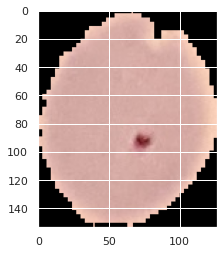

In [77]:
#visualizando
im = plt.imread('/content/cell_images/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_180.png')
plt.imshow(im)
plt.show()

In [78]:
#instalando splitfolders para separar treino e teste
pip install split-folders

In [79]:
#separando em treino e teste (usei os valores de default de 80%/20%)
import split_folders
split_folders.ratio("/content/cell_images", output="output", seed=1337, ratio=(.8, .2)) 

Copying files: 27560 files [00:04, 6126.96 files/s]




---



---



Pré-processamento dos dados

In [80]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# reescalonando as imagens para 1./255
train_data = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)
test_data = ImageDataGenerator(rescale=1./255)
train_generator = train_data.flow_from_directory(
        "/content/output/train", 
        target_size=(150, 150),  # todas as imagens serão redimensionadas para 150x150
        batch_size=20,
        class_mode='binary')
validation_generator = test_data.flow_from_directory(
        "/content/output/val",
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [0]:
#construindo a arquitetura da rede cnn

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

img_input = layers.Input(shape=(150, 150, 3))
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Convolution2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)
model = Model(img_input, output)

In [0]:
#compilando o modelo
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adadelta
model.compile(loss='binary_crossentropy',
             optimizer=Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0),
             metrics=['acc'])

In [110]:
# Vamos correr!
history = model.fit_generator(
     train_generator,
     steps_per_epoch=30,  # 2000 images = batch_size * steps
     epochs=500,
     validation_data=validation_generator,
     validation_steps=50,  # 1000 images = batch_size * steps
     verbose=2)

Epoch 1/500
30/30 - 22s - loss: 0.1860 - acc: 0.9383 - val_loss: 0.1329 - val_acc: 0.9540
Epoch 2/500
30/30 - 21s - loss: 0.1625 - acc: 0.9420 - val_loss: 0.1306 - val_acc: 0.9640
Epoch 3/500
30/30 - 21s - loss: 0.1691 - acc: 0.9433 - val_loss: 0.0934 - val_acc: 0.9627
Epoch 4/500
30/30 - 21s - loss: 0.1822 - acc: 0.9367 - val_loss: 0.2838 - val_acc: 0.9160
Epoch 5/500
30/30 - 22s - loss: 0.2060 - acc: 0.9267 - val_loss: 0.2083 - val_acc: 0.9280
Epoch 6/500
30/30 - 22s - loss: 0.1629 - acc: 0.9433 - val_loss: 0.1308 - val_acc: 0.9620
Epoch 7/500
30/30 - 21s - loss: 0.1913 - acc: 0.9333 - val_loss: 0.2178 - val_acc: 0.9440
Epoch 8/500
30/30 - 21s - loss: 0.2245 - acc: 0.9150 - val_loss: 0.1248 - val_acc: 0.9637
Epoch 9/500
30/30 - 21s - loss: 0.1376 - acc: 0.9617 - val_loss: 0.1971 - val_acc: 0.9440
Epoch 10/500
30/30 - 22s - loss: 0.2298 - acc: 0.9050 - val_loss: 0.1582 - val_acc: 0.9440
Epoch 11/500
30/30 - 22s - loss: 0.1846 - acc: 0.9333 - val_loss: 0.1878 - val_acc: 0.9440
Epoch 12

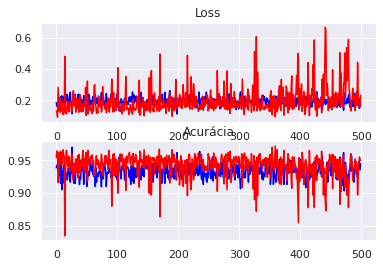

In [113]:
#plotanod a acurácia do treino e do teste

import sys
from matplotlib import pyplot

# plot loss

pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='red', label='test')

# plot accuracy
pyplot.subplot(212)
pyplot.title('Acurácia')
pyplot.plot(history.history['acc'], color='blue', label='train')
pyplot.plot(history.history['val_acc'], color='red', label='test')
pyplot.show()

In [114]:
#plotando os resultados na matriz de confusão

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report  

results = confusion_matrix 
print ('Matriz de confusão :')
print(results) 
print ('score de acurácia :',history.history['acc'] )
print ('Report : ')
print (history.history['val_acc'])


Matriz de confusão :
<function confusion_matrix at 0x7f8b2a2b0400>
score de acurácia : [0.9383333325386047, 0.9419795274734497, 0.9433333277702332, 0.9366666674613953, 0.9266666769981384, 0.9433333277702332, 0.9333333373069763, 0.9150000214576721, 0.9616666436195374, 0.9049999713897705, 0.9333333373069763, 0.925000011920929, 0.9416666626930237, 0.9150000214576721, 0.9449999928474426, 0.9233333468437195, 0.9300000071525574, 0.9300000071525574, 0.9200000166893005, 0.9333333373069763, 0.9383333325386047, 0.9316666722297668, 0.92166668176651, 0.9166666865348816, 0.9383333325386047, 0.9300000071525574, 0.9700000286102295, 0.9300000071525574, 0.9366666674613953, 0.9150000214576721, 0.9416666626930237, 0.9150000214576721, 0.9366666674613953, 0.9316666722297668, 0.949999988079071, 0.9300000071525574, 0.925000011920929, 0.9266666769981384, 0.9129692912101746, 0.9233333468437195, 0.92166668176651, 0.9399999976158142, 0.9350000023841858, 0.9399999976158142, 0.9366666674613953, 0.9133333563804626,